# Performance of DiPriMeFlip for various hyperparameters

This notebook contains plots for the proposed scheme (DiPriMeFlip) with various hyperparameter settings.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as rn
import random
import pandas as pd
import csv
import os
from sklearn.model_selection import train_test_split
from scipy.stats import t as student_t

from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', cmap='viridis')

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import sys
sys.path.append("../Classes")
sys.path.append("../Baselines")

In [2]:
from DiPrime import *
from DiPrimeFlip import *
from RandForest_DP import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
# Function to generate dictionary of attribute ranges/values 
## X: Data (M points x N features) (M,N) numpy
## cat_idx: List of categorical feature indices
def gen_attdict(X,cat_idx):
    A = dict()
    for j in range(np.shape(X)[1]):
        if j in cat_idx:
            A[j] = list(np.unique(X[:,j]))
        else:
            A[j] = np.array([np.amin(X[:,j]),np.amax(X[:,j])])
    return A

## Regression

### Appliances Energy Prediction Dataset

#### Read data:

In [99]:
from datetime import date, datetime

data_path = "../Datasets/Appliances_Energy_Prediction/energydata_complete.csv"
df_raw = pd.read_csv(data_path)
#df_raw.columns


In [100]:
df = df_raw.copy()
Mp,Np = df.shape

df['Month'] = pd.Series([(datetime.strptime(df.at[i,'date'],"%Y-%m-%d %H:%M:%S")
                                                         ).month for i in range(Mp)])
df['Day'] = pd.Series([(datetime.strptime(df.at[i,'date'],"%Y-%m-%d %H:%M:%S")
                                                         ).day for i in range(Mp)])
del df['date'], df['rv1'], df['rv2']
#print(df.columns)

X = df.drop(columns='Appliances').to_numpy()
y = df['Appliances'].to_numpy()
y = (y - np.amin(y))/(np.amax(y)-np.amin(y))
X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.1)

In [101]:
M,N = np.shape(X_tr)
cat_idx = [25]
bnds_y = np.array([0,np.amax(y_tr,axis=0)]) # Bound on target value
A = gen_attdict(X,cat_idx)


### Variation with $\epsilon$ and budget split

##### $part=False$

In [10]:
eps = [3,10,30,100] # Privacy budget
f_med = [0.2,0.4,0.6,0.8] # Privacy budget split
err_budget = np.zeros((len(eps),len(f_med)))

for i in tqdm(range(len(eps))):
    for j in range(len(f_med)):
        dpmf = DiPrimeFlipForest(n_trees=10,max_depth=8,max_features=10,partition=False)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i],b_med=f_med[j])
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_budget[i,j] = err_dpmf
#print(err_budget)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:54<00:00, 119.43s/it]


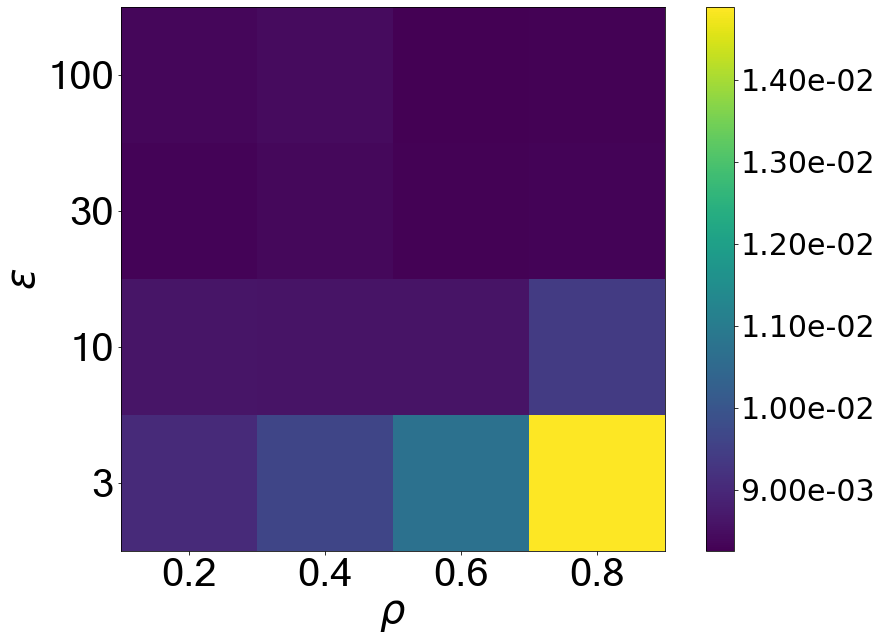

In [12]:
fig1, ax1 = plt.subplots(figsize=(15,10))
img1 = ax1.imshow(err_budget,origin ='lower')
ax1.set_yticks(np.arange(len(eps)))
ax1.set_xticks(np.arange(len(f_med)))
ax1.set_yticklabels(eps,fontsize=40,fontname='Microsoft Sans Serif')
ax1.set_xticklabels(f_med,fontsize=40,fontname='Microsoft Sans Serif')
ax1.set_xlabel(r'$\rho$',fontsize=40,fontname='Microsoft Sans Serif')
ax1.set_ylabel(r'$\epsilon$',fontsize=40,fontname='Microsoft Sans Serif')
cb1 = fig1.colorbar(img1,ax=ax1,format='%.2e')
for lab in cb1.ax.get_yticklabels():
    lab.set_fontsize(30)
plt.savefig('../DiPrimeFlip_Results/eps_split.png',bbox_inches='tight')

##### $part=True$

In [13]:
eps = [3,10,30,100] # Privacy budget
f_med = [0.2,0.4,0.6,0.8] # Privacy budget split
err_budget_part = np.zeros((len(eps),len(f_med)))

for i in tqdm(range(len(eps))):
    for j in range(len(f_med)):
        dpmf = DiPrimeFlipForest(n_trees=10,max_depth=8,max_features=10,partition=True)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i],b_med=f_med[j])
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_budget_part[i,j] = err_dpmf
#print(err_budget_part)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:52<00:00, 88.08s/it]


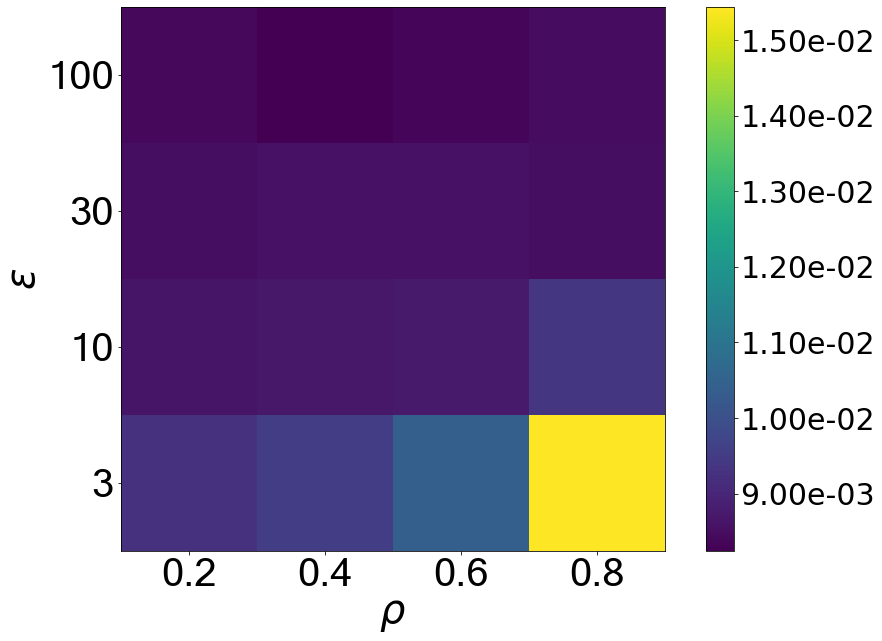

In [14]:
fig2, ax2 = plt.subplots(figsize=(15,10))
img2 = ax2.imshow(err_budget_part,origin='lower')
ax2.set_yticks(np.arange(len(eps)))
ax2.set_xticks(np.arange(len(f_med)))
ax2.set_yticklabels(eps,fontsize=40,fontname='Microsoft Sans Serif')
ax2.set_xticklabels(f_med,fontsize=40,fontname='Microsoft Sans Serif')
ax2.set_xlabel(r'$\rho$',fontsize=40,fontname='Microsoft Sans Serif')
ax2.set_ylabel(r'$\epsilon$',fontsize=40,fontname='Microsoft Sans Serif')
cb2 = fig2.colorbar(img2,ax=ax2,format='%.2e')
for lab in cb2.ax.get_yticklabels():
    lab.set_fontsize(30)
plt.savefig('../DiPrimeFlip_Results/eps_split_part.png',bbox_inches='tight')

### Variation with $K$ and number of trees

##### $part=False$

In [15]:
K = [1,3,10,20] # Number of features selected
nT = [1,3,10,30] # Number of trees
err_kn = np.zeros((len(K),len(nT)))

for i in tqdm(range(len(K))):
    for j in range(len(nT)):
        dpmf = DiPrimeFlipForest(n_trees=nT[j],max_depth=8,max_features=K[i],partition=False)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_kn[i,j] = err_dpmf
#print(err_kn)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:36<00:00, 117.98s/it]


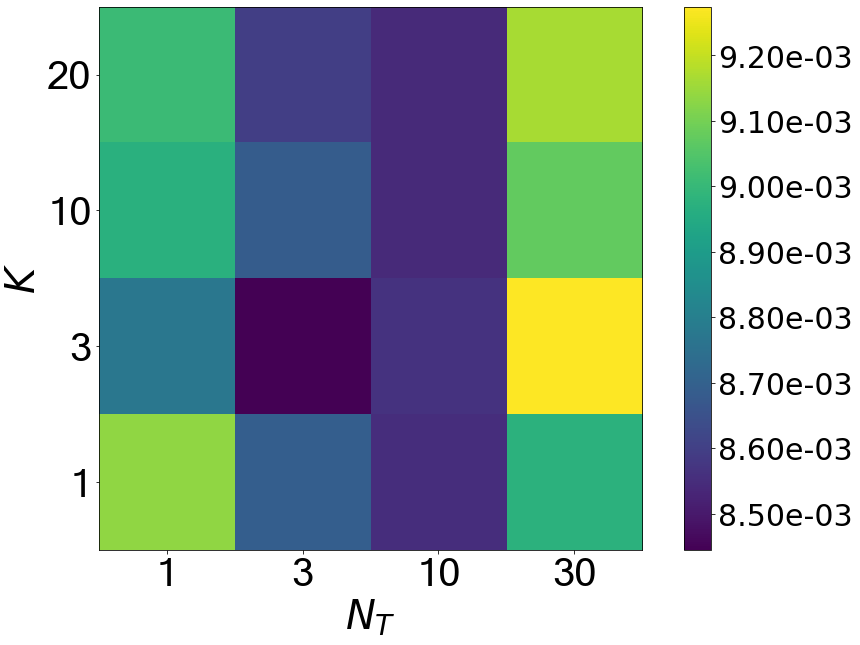

In [16]:
fig3, ax3 = plt.subplots(figsize=(15,10))
img3 = ax3.imshow(err_kn,origin='lower')
ax3.set_yticks(np.arange(len(K)))
ax3.set_xticks(np.arange(len(nT)))
ax3.set_yticklabels(K,fontsize=40,fontname='Microsoft Sans Serif')
ax3.set_xticklabels(nT,fontsize=40,fontname='Microsoft Sans Serif')
ax3.set_xlabel(r'$N_T$',fontsize=40,fontname='Microsoft Sans Serif')
ax3.set_ylabel(r'$K$',fontsize=40,fontname='Microsoft Sans Serif')
cb3 = fig3.colorbar(img3,ax=ax3,format='%.2e')
for lab in cb3.ax.get_yticklabels():
    lab.set_fontsize(30)
plt.savefig('../DiPrimeFlip_Results/numtree_K.png',bbox_inches='tight')

##### $part=True$

In [17]:
K = [1,3,10,20] # Number of features selected
nT = [1,3,10,30] # Number of trees
err_kn_part = np.zeros((len(K),len(nT)))

for i in tqdm(range(len(K))):
    for j in range(len(nT)):
        dpmf = DiPrimeFlipForest(n_trees=nT[j],max_depth=8,max_features=K[i],partition=True)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_kn_part[i,j] = err_dpmf
#print(err_kn_part)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:37<00:00, 87.00s/it]


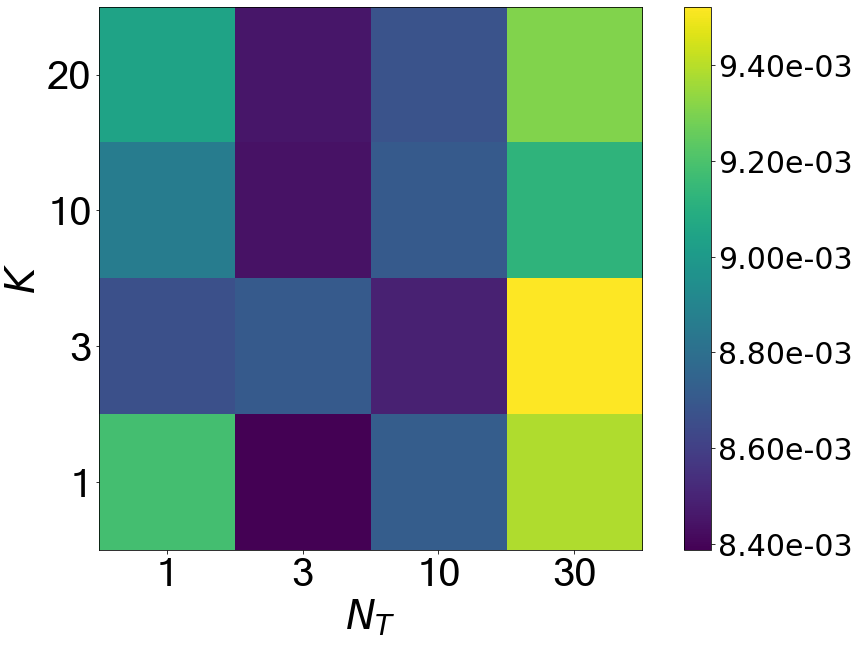

In [18]:
fig4, ax4 = plt.subplots(figsize=(15,10))
img4 = ax4.imshow(err_kn_part,origin='lower')
ax4.set_yticks(np.arange(len(K)))
ax4.set_xticks(np.arange(len(nT)))
ax4.set_yticklabels(K,fontsize=40,fontname='Microsoft Sans Serif')
ax4.set_xticklabels(nT,fontsize=40,fontname='Microsoft Sans Serif')
ax4.set_xlabel(r'$N_T$',fontsize=40,fontname='Microsoft Sans Serif')
ax4.set_ylabel(r'$K$',fontsize=40,fontname='Microsoft Sans Serif')
cb4 = fig4.colorbar(img4,ax=ax4,format='%.2e')
for lab in cb4.ax.get_yticklabels():
    lab.set_fontsize(30)
plt.savefig('../DiPrimeFlip_Results/numtree_K_part.png',bbox_inches='tight')

In [102]:
num_runs = 5  # Number of runs of each algorithm (for error bars)
algo_names = ['Random forest', 'ERT', 'Median trees', 'DiPriMe', 'DiPriMeFlip', 'DP-ERT']

In [103]:
def plot_werr(x_arr, y_arr, label_list, x_label, conf=0.95, jitter=0.03, loc=(0,0)):
    marker_list = ['*', 'X', 'P', '^', 'v', 'd']
    color_list = ['b', 'r', 'm', 'g', 'k', 'c']
    nrun = np.shape(y_arr)[2]
    x_arr = np.array(x_arr)
    x_jitter = jitter*(x_arr[1]-x_arr[0])
    
    plt.figure(figsize=(15,10))
    for q in range(np.shape(y_arr)[0]):  # Iterate over all algorithms
        y_mean = np.mean(y_arr[q], axis=1)  # Mean y
        y_err = (np.std(y_arr[q], axis=1)/np.sqrt(nrun))*(student_t.interval(0.95, df=nrun-1)[1])
        # plt.plot(x_arr, y_mean ,c=color_list[q],marker=marker_list[q],markersize=20,label=label_list[q])
        plt.errorbar(x_arr+x_jitter*(q-np.shape(y_arr)[0]/2), y_mean, y_err,
                     linestyle='-', marker=marker_list[q], ms=20, c=color_list[q], label=label_list[q])

    plt.xticks(x_arr)
    plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
    plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
    plt.xlabel(x_label,fontsize=40,fontname='Microsoft Sans Serif')
    plt.ylabel("MSE",fontsize=40,fontname='Microsoft Sans Serif')
    plt.legend(prop={'size':32,'family':'Microsoft Sans Serif'},loc=loc)

In [104]:
def plot_semilogx_werr(x_arr, y_arr, label_list, conf=0.95, jitter=0.03, loc=(0,0), ncol=1):
    marker_list = ['*', 'X', 'P', '^', 'v', 'd']
    color_list = ['b', 'r', 'm', 'g', 'k', 'c']
    nrun = np.shape(y_arr)[2]
    x_arr = np.array(x_arr)
    x_jitter = jitter*(np.log10(x_arr[1])-np.log10(x_arr[0]))
    
    plt.figure(figsize=(15,10))
    for q in range(np.shape(y_arr)[0]):  # Iterate over all algorithms
        y_mean = np.mean(y_arr[q], axis=1)  # Mean y
        y_err = (np.std(y_arr[q], axis=1)/np.sqrt(nrun))*(student_t.interval(0.95, df=nrun-1)[1])
        plt.semilogx(x_arr*np.power(10,x_jitter*(q-np.shape(y_arr)[0]/2)), y_mean ,
                     c=color_list[q],marker=marker_list[q],markersize=20,label=label_list[q])
        plt.errorbar(x_arr*np.power(10,x_jitter*(q-np.shape(y_arr)[0]/2)), y_mean, y_err,
                     fmt='none', c=color_list[q])

    plt.xticks(x_arr)
    plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
    plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
    plt.xlabel(r"$\epsilon$",fontsize=40,fontname='Microsoft Sans Serif')
    plt.ylabel("MSE",fontsize=40,fontname='Microsoft Sans Serif')
    plt.legend(prop={'size':32,'family':'Microsoft Sans Serif'}, loc=loc, ncol=ncol)

### Variation with maximum depth ($part=True$)

In [105]:
d = [3,4,5,6,7,8,9,10] # Number of features selected
err_d = np.zeros((6,len(d),num_runs))
# inner_loop = tqdm(range(len(d)))

for r in tqdm(range(num_runs)):
    X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.1)
    for i in range(len(d)):
        rf = RandomForestRegressor(n_estimators=10,max_depth=d[i],min_samples_leaf=5,max_features=10)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
        err_d[0,i,r] = err_rf

        rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=d[i],min_samples_leaf=5,max_features=10)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum((y_tst-y_base)**2/len(y_tst))
        err_d[1,i,r] = err_base

        mf = DiPrimeForest(n_trees=10,max_depth=d[i],max_features=10,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = mf.predict(X_tst,cat_idx)
        err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
        err_d[2,i,r] = err_mf

        dpmf = DiPrimeForest(n_trees=10,max_depth=d[i],max_features=10,partition=True)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_d[3,i,r] = err_dpmf

        dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=d[i],max_features=10,partition=True)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpdmf = dpdmf.predict(X_tst,cat_idx)
        err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
        err_d[4,i,r] = err_dpdmf

        dprf = DPRandForest(n_trees=10,max_depth=d[i],max_features=1)
        dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
        y_dprf = dprf.predict(X_tst,cat_idx)
        err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
        err_d[5,i,r] = err_dprf

#print(err_d)

100%|██████████| 5/5 [06:59<00:00, 83.86s/it]


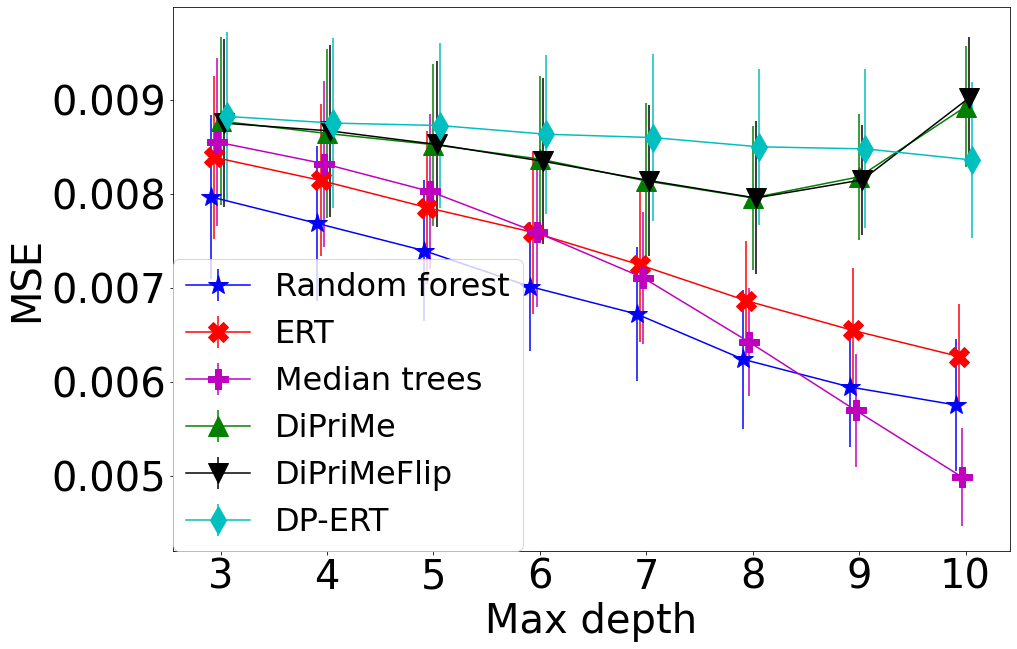

In [106]:
plot_werr(d, err_d, algo_names, 'Max depth', jitter=0.03)
plt.savefig('../DiPriMeFlip_Results/err_d.png',bbox_inches='tight')

### Variation with number of trees ($part=True$)

In [107]:
NT = [1,4,7,10,13,16,19,22,25,28] # Number of features selected
err_nt = np.zeros((6,len(NT),num_runs))

for r in tqdm(range(num_runs)):
    X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.1)
    for i in range(len(NT)):

        rf = RandomForestRegressor(n_estimators=NT[i],max_depth=8,min_samples_leaf=5,max_features=10)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
        err_nt[0,i,r] = err_rf

        rf_base = ExtraTreesRegressor(n_estimators=NT[i],max_depth=8,min_samples_leaf=5,max_features=10)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum((y_tst-y_base)**2/len(y_tst))
        err_nt[1,i,r] = err_base

        mf = DiPrimeForest(n_trees=NT[i],max_depth=8,max_features=10,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = mf.predict(X_tst,cat_idx)
        err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
        err_nt[2,i,r] = err_mf

        dpmf = DiPrimeForest(n_trees=NT[i],max_depth=8,max_features=10,partition=True)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_nt[3,i,r] = err_dpmf

        dpdmf = DiPrimeFlipForest(n_trees=NT[i],max_depth=8,max_features=10,partition=True)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpdmf = dpdmf.predict(X_tst,cat_idx)
        err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
        err_nt[4,i,r] = err_dpdmf

        dprf = DPRandForest(n_trees=NT[i],max_depth=8,max_features=1)
        dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
        y_dprf = dprf.predict(X_tst,cat_idx)
        err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
        err_nt[5,i,r] = err_dprf


100%|██████████| 5/5 [13:20<00:00, 160.12s/it]


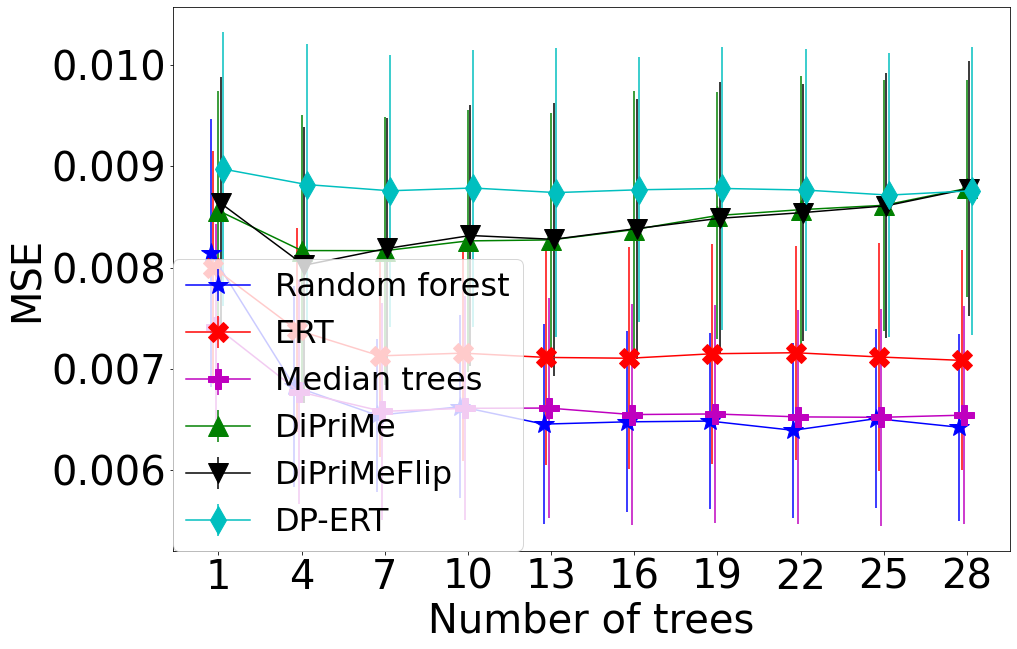

In [108]:
plot_werr(NT, err_nt, algo_names, 'Number of trees', jitter=0.03)
plt.savefig('../DiPriMeFlip_Results/err_ntree.png',bbox_inches='tight')

### Variation with $\epsilon$ ($part=True$)

In [109]:
eps = [0.3,1,3,10,30,100,300] # Number of features selected
err_eps = np.zeros((6,len(eps),num_runs))

for r in tqdm(range(num_runs)):
    X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.1)
    for i in range(len(eps)):

        rf = RandomForestRegressor(n_estimators=10,max_depth=5,min_samples_leaf=5,max_features=10)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
        err_eps[0,i,r] = err_rf

        rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=5,min_samples_leaf=5,max_features=10)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum((y_tst-y_base)**2/len(y_tst))
        err_eps[1,i,r] = err_base

        mf = DiPrimeForest(n_trees=10,max_depth=5,max_features=10,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = mf.predict(X_tst,cat_idx)
        err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
        err_eps[2,i,r] = err_mf

        dpmf = DiPrimeForest(n_trees=10,max_depth=5,max_features=10,partition=True)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2*eps[i],b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_eps[3,i,r] = err_dpmf

        dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=5,max_features=10,partition=True)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2*eps[i],b_med=0.5)
        y_dpdmf = dpdmf.predict(X_tst,cat_idx)
        err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
        err_eps[4,i,r] = err_dpdmf

        dprf = DPRandForest(n_trees=10,max_depth=5,max_features=1)
        dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i])
        y_dprf = dprf.predict(X_tst,cat_idx)
        err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
        err_eps[5,i,r] = err_dprf

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


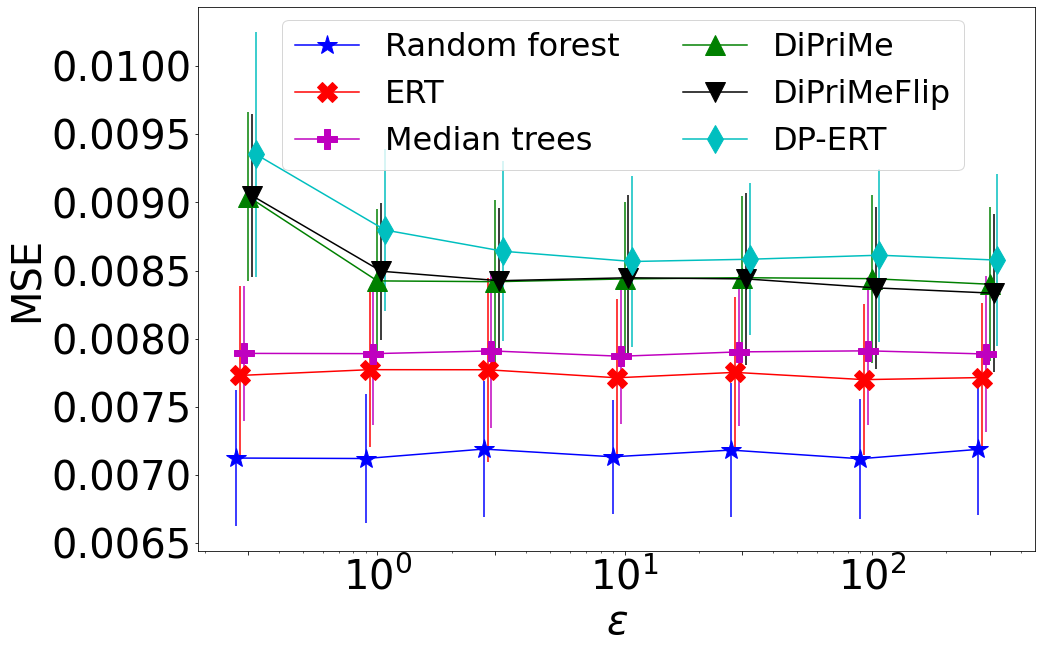

In [110]:
plot_semilogx_werr(eps, err_eps, algo_names, jitter=0.03, loc=(0.1,0.7), ncol=2)
plt.savefig('../DiPriMeFlip_Results/err_eps.png',bbox_inches='tight')

### Variation with maximum depth ($part=False$)

In [111]:
d = [3,4,5,6,7,8,9,10] # Number of features selected
err_d_all = np.zeros((6,len(d),num_runs))

for r in tqdm(range(num_runs)):
    X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.1)
    for i in range(len(d)):
        rf = RandomForestRegressor(n_estimators=10,max_depth=d[i],min_samples_leaf=5,max_features=10)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
        err_d_all[0,i,r] = err_rf

        rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=d[i],min_samples_leaf=5,max_features=10)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum((y_tst-y_base)**2/len(y_tst))
        err_d_all[1,i,r] = err_base

        mf = DiPrimeForest(n_trees=10,max_depth=d[i],max_features=10,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = mf.predict(X_tst,cat_idx)
        err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
        err_d_all[2,i,r] = err_mf

        dpmf = DiPrimeForest(n_trees=10,max_depth=d[i],max_features=10,partition=False)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_d_all[3,i,r] = err_dpmf

        dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=d[i],max_features=10,partition=False)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpdmf = dpdmf.predict(X_tst,cat_idx)
        err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
        err_d_all[4,i,r] = err_dpdmf

        dprf = DPRandForest(n_trees=10,max_depth=d[i],max_features=1)
        dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
        y_dprf = dprf.predict(X_tst,cat_idx)
        err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
        err_d_all[5,i,r] = err_dprf

100%|██████████| 5/5 [09:57<00:00, 119.57s/it]


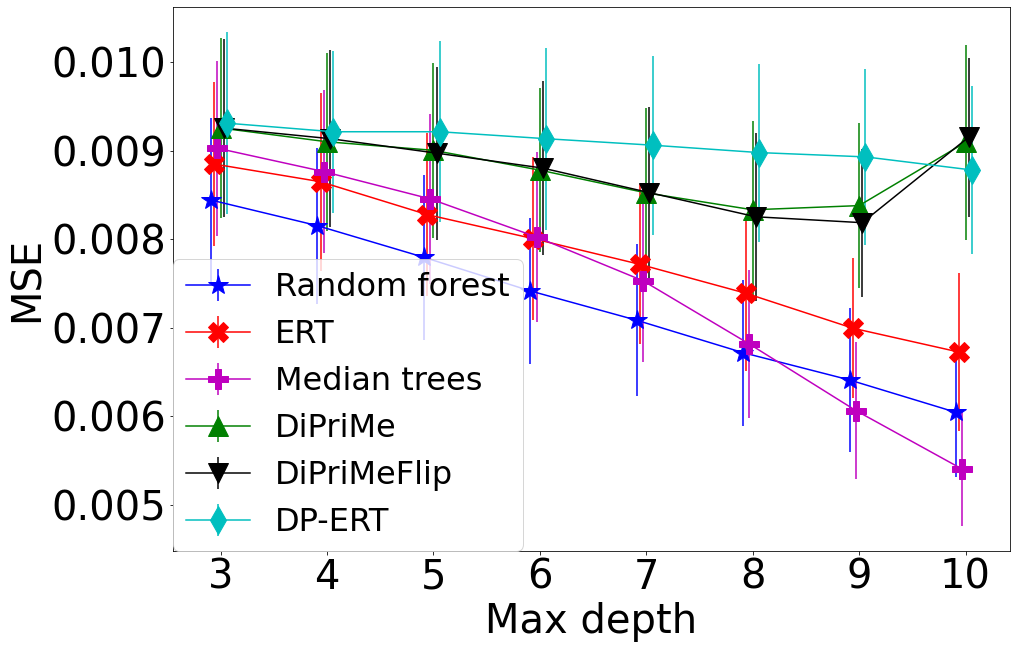

In [112]:
plot_werr(d, err_d_all, algo_names, 'Max depth', jitter=0.03)
plt.savefig('../DiPriMeFlip_Results/err_d-all-data.png',bbox_inches='tight')

### Variation with number of trees ($part=False$)

In [113]:
NT = [1,4,7,10,13,16,19,22,25,28] # Number of features selected
err_nt_all = np.zeros((6,len(NT),num_runs))

for r in tqdm(range(num_runs)):
    X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.1)
    for i in range(len(NT)):

        rf = RandomForestRegressor(n_estimators=NT[i],max_depth=8,min_samples_leaf=5,max_features=10)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
        err_nt_all[0,i,r] = err_rf

        rf_base = ExtraTreesRegressor(n_estimators=NT[i],max_depth=8,min_samples_leaf=5,max_features=10)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum((y_tst-y_base)**2/len(y_tst))
        err_nt_all[1,i,r] = err_base

        mf = DiPrimeForest(n_trees=NT[i],max_depth=8,max_features=10,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = mf.predict(X_tst,cat_idx)
        err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
        err_nt_all[2,i,r] = err_mf

        dpmf = DiPrimeForest(n_trees=NT[i],max_depth=8,max_features=10,partition=False)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_nt_all[3,i,r] = err_dpmf

        dpdmf = DiPrimeFlipForest(n_trees=NT[i],max_depth=8,max_features=10,partition=False)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
        y_dpdmf = dpdmf.predict(X_tst,cat_idx)
        err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
        err_nt_all[4,i,r] = err_dpdmf

        dprf = DPRandForest(n_trees=NT[i],max_depth=8,max_features=1)
        dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
        y_dprf = dprf.predict(X_tst,cat_idx)
        err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
        err_nt_all[5,i,r] = err_dprf

100%|██████████| 5/5 [19:56<00:00, 239.35s/it]


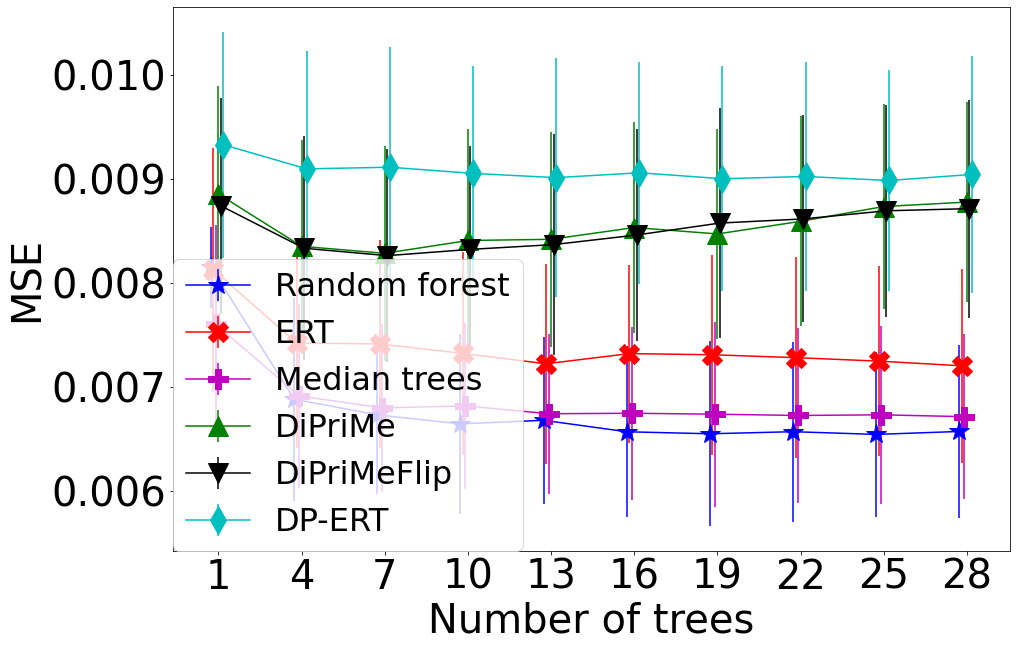

In [114]:
plot_werr(NT, err_nt_all, algo_names, 'Number of trees', jitter=0.03)
plt.savefig('../DiPriMeFlip_Results/err_ntree-all-data.png',bbox_inches='tight')

### Variation with $\epsilon$ ($part=False$)

In [115]:
eps = [0.3,1,3,10,30,100,300] # Number of features selected
err_eps_all = np.zeros((6,len(eps),num_runs))

for r in tqdm(range(num_runs)):
    X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.1)
    for i in range(len(eps)):

        rf = RandomForestRegressor(n_estimators=10,max_depth=5,min_samples_leaf=5,max_features=10)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
        err_eps_all[0,i,r] = err_rf

        rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=5,min_samples_leaf=5,max_features=10)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum((y_tst-y_base)**2/len(y_tst))
        err_eps_all[1,i,r] = err_base

        mf = DiPrimeForest(n_trees=10,max_depth=5,max_features=10,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = mf.predict(X_tst,cat_idx)
        err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
        err_eps_all[2,i,r] = err_mf

        dpmf = DiPrimeForest(n_trees=10,max_depth=5,max_features=10,partition=False)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2*eps[i],b_med=0.5)
        y_dpmf = dpmf.predict(X_tst,cat_idx)
        err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
        err_eps_all[3,i,r] = err_dpmf

        dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=5,max_features=10,partition=False)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2*eps[i],b_med=0.5)
        y_dpdmf = dpdmf.predict(X_tst,cat_idx)
        err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
        err_eps_all[4,i,r] = err_dpdmf

        dprf = DPRandForest(n_trees=10,max_depth=5,max_features=1)
        dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i])
        y_dprf = dprf.predict(X_tst,cat_idx)
        err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
        err_eps_all[5,i,r] = err_dprf


100%|██████████| 5/5 [03:23<00:00, 40.73s/it]


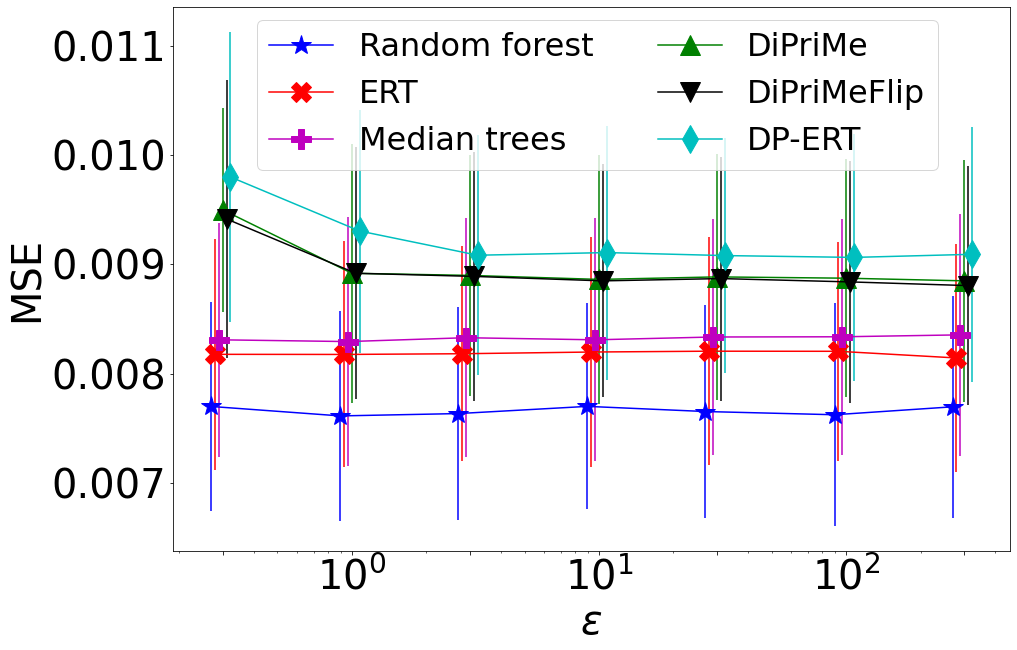

In [116]:
plot_semilogx_werr(eps, err_eps_all, algo_names, jitter=0.03, loc=(0.1,0.7), ncol=2)
plt.savefig('../DiPriMeFlip_Results/err_eps-all-data.png',bbox_inches='tight')

## Classifcation

In [117]:
from DP_DF.DP_SysFor import DP_SysFor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from DiPrime_Class import *
from DiPrimeFlip_Class import *
from RandForest_DP_Class import *
from dprf import DPRF

In [118]:
def plot_acc_semilogx_werr(x_arr, y_arr, label_list, conf=0.95, jitter=0.03, loc=(0,0), ncol=1):
    marker_list = ['*', 'X', 'P', '^', 'v', 'p', 'h', 'd']
    color_list = ['b', 'r', 'm', 'g', 'k', 'c', 'tab:purple', 'tab:brown']
    nrun = np.shape(y_arr)[2]
    x_arr = np.array(x_arr)
    x_jitter = jitter*(np.log10(x_arr[1])-np.log10(x_arr[0]))
    
    plt.figure(figsize=(15,10))
    for q in range(np.shape(y_arr)[0]):  # Iterate over all algorithms
        y_mean = np.mean(y_arr[q], axis=1)  # Mean y
        y_err = (np.std(y_arr[q], axis=1)/np.sqrt(nrun))*(student_t.interval(0.95, df=nrun-1)[1])
        plt.semilogx(x_arr*np.power(10,x_jitter*(q-np.shape(y_arr)[0]/2)), y_mean ,
                     c=color_list[q],marker=marker_list[q],markersize=20,label=label_list[q])
        plt.errorbar(x_arr*np.power(10,x_jitter*(q-np.shape(y_arr)[0]/2)), y_mean, y_err,
                     fmt='none', c=color_list[q])

    plt.xticks(x_arr)
    plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
    plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
    plt.xlabel(r"$\epsilon$",fontsize=40,fontname='Microsoft Sans Serif')
    plt.ylabel("Accuracy",fontsize=40,fontname='Microsoft Sans Serif')
    plt.legend(prop={'size':32,'family':'Microsoft Sans Serif'}, loc=loc, ncol=ncol)

### Banknote Authentication:

In [119]:
data_path = "../Datasets/Banknote_Authentication/data_banknote_authentication.txt"
df_raw = pd.read_csv(data_path,index_col=False,
                     names=['variance','skewness','curtosis','entropy','class'])
attribute_names = df_raw.columns[:-1]

df = pd.DataFrame()
for col in df_raw.columns:
    if col != 'class':
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
df['class'] = df_raw['class']

Xycat = df.to_numpy()
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

cat_idx = []
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = [0,1]

In [120]:
num_runs = 5  # Number of runs of each algorithm (for error bars)
algo_names = ['Random forest', 'ERT', 'Median trees', 'DiPriMe', 'DiPriMeFlip', 'DP-ERT', 'DP-DF', 'DP-RF']

### $part = True$

In [121]:
d = 5  # Max tree depth
eps = [0.1,0.3,1,3,10,30,100,300] # Epsilon selected
acc_eps = np.zeros((8,len(eps),num_runs))

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]
    
    Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
    Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
    y_tst_list = list(y[test_idx])

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]
    
    for i in range(len(eps)):

        rf = RandomForestClassifier(n_estimators=10,max_depth=d,min_samples_leaf=5,max_features=4)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)
        acc_eps[0,i,r] = 1-err_rf

        rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d,min_samples_leaf=5,max_features=4)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)
        acc_eps[1,i,r] = 1-err_base

        mf = DiPrimeCForest(n_trees=10,max_depth=5,max_features=4,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
        err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)
        acc_eps[2,i,r] = 1-err_mf

        dpmf = DiPrimeCForest(n_trees=10,max_depth=5,max_features=4,partition=True)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i],b_med=0.5)
        y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
        err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)
        acc_eps[3,i,r] = 1-err_dpmf

        dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=5,max_features=4,partition=True)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i],b_med=0.5)
        y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
        err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)
        acc_eps[4,i,r] = 1-err_dpdmf

        dperf = DPRandCForest(n_trees=10,max_depth=d,max_features=1)
        dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2*eps[i])
        y_dperf = dperf.predict(X_tst,cat_idx)
        err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)
        acc_eps[5,i,r] = 1-err_dperf

        dpdf = DP_SysFor(records=Xycat_tr, max_height = d, target_attribute_index=4, num_trees=10, 
                     epsilon_budget=0.5*eps[i],attribute_names=attribute_names)
        y_dpdf = dpdf.classify_list(Xcat_tst)
        acc_eps[6,i,r] = 1-sum([y_dpdf[i] != y_tst_list[i] for i in range(len(y_tst))])/len(y_tst_list)

        dprf = DPRF(n_trees=10,max_depth=d,max_features=4)
        dprf.fit(X_tr_cat,y_tr,Acat,C,0.25,eps=eps[i])
        y_dprf = dprf.predict(X_tst_cat,C)
        err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)
        acc_eps[7,i,r] = 1-err_dprf


100%|██████████| 5/5 [00:36<00:00,  7.33s/it]


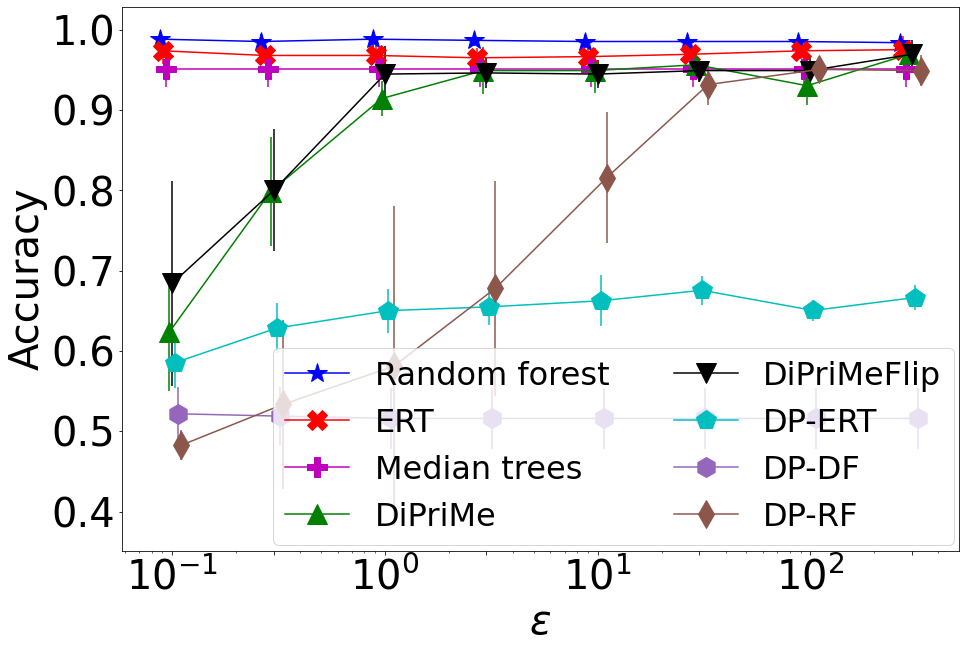

In [122]:
plot_acc_semilogx_werr(eps, acc_eps, algo_names, jitter=0.03, loc=(0.18,0.01), ncol=2)
plt.savefig('../DiPriMeFlip_Results/acc_eps.png',bbox_inches='tight')

### $part = False$

In [123]:
d = 5  # Max tree depth
eps = [0.1,0.3,1,3,10,30,100,300] # Epsilon selected
acc_eps_all = np.zeros((8,len(eps),num_runs))

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]
    
    Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
    Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
    y_tst_list = list(y[test_idx])

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]
    
    for i in range(len(eps)):

        rf = RandomForestClassifier(n_estimators=10,max_depth=d,min_samples_leaf=5,max_features=4)
        rf.fit(X_tr,y_tr)
        y_rf = rf.predict(X_tst)
        err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)
        acc_eps_all[0,i,r] = 1-err_rf

        rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d,min_samples_leaf=5,max_features=4)
        rf_base.fit(X_tr,y_tr)
        y_base = rf_base.predict(X_tst)
        err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)
        acc_eps_all[1,i,r] = 1-err_base

        mf = DiPrimeCForest(n_trees=10,max_depth=5,max_features=4,partition=False)
        mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
        y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
        err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)
        acc_eps_all[2,i,r] = 1-err_mf

        dpmf = DiPrimeCForest(n_trees=10,max_depth=5,max_features=4,partition=False)
        dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i],b_med=0.5)
        y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
        err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)
        acc_eps_all[3,i,r] = 1-err_dpmf

        dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=5,max_features=4,partition=False)
        dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=eps[i],b_med=0.5)
        y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
        err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)
        acc_eps_all[4,i,r] = 1-err_dpdmf

        dperf = DPRandCForest(n_trees=10,max_depth=d,max_features=1)
        dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2*eps[i])
        y_dperf = dperf.predict(X_tst,cat_idx)
        err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)
        acc_eps_all[5,i,r] = 1-err_dperf

        dpdf = DP_SysFor(records=Xycat_tr, max_height = d, target_attribute_index=4, num_trees=10, 
                     epsilon_budget=0.5*eps[i],attribute_names=attribute_names)
        y_dpdf = dpdf.classify_list(Xcat_tst)
        acc_eps_all[6,i,r] = 1-sum([y_dpdf[i] != y_tst_list[i] for i in range(len(y_tst))])/len(y_tst_list)

        dprf = DPRF(n_trees=10,max_depth=d,max_features=4)
        dprf.fit(X_tr_cat,y_tr,Acat,C,0.25,eps=eps[i])
        y_dprf = dprf.predict(X_tst_cat,C)
        err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)
        acc_eps_all[7,i,r] = 1-err_dprf

100%|██████████| 5/5 [00:41<00:00,  8.25s/it]


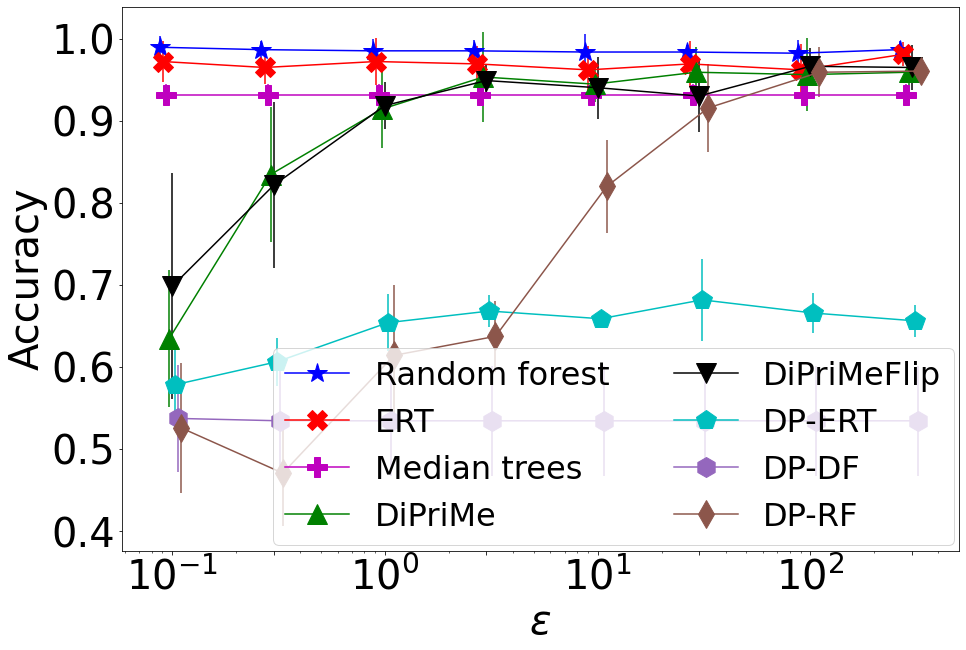

In [124]:
plot_acc_semilogx_werr(eps, acc_eps_all, algo_names, jitter=0.03, loc=(0.18,0.01), ncol=2)
plt.savefig('../DiPriMeFlip_Results/acc_eps-all-data.png',bbox_inches='tight')

### Histogram of node counts

In [50]:
# Function to traverse every tree in a forest and query stored counts
## Returns a dictionary with lists of counts at each level of every tree (depth is dictionary key) 
def find_counts(TFor):
    count_dict = dict()
    for i in range(TFor.trees[0].max_depth+1):
        count_dict[i] = []
    for tree in TFor.trees:
        treeList = [tree]
        while treeList: # Until all nodes explored
            currTree = treeList.pop(0)
            count_dict[currTree.depth].append(currTree.count)
            if currTree.left is not None and currTree.right is not None:
                treeList.extend([currTree.left,currTree.right])
    return count_dict

# Function to traverse every tree in a forest and query stored counts and find splt fraction
## Returns a dictionary with lists of fraction at each level of every tree (depth is dictionary key) 
def find_frac(TFor):
    frac_dict = dict()
    for i in range(TFor.trees[0].max_depth):
        frac_dict[i] = []
        
    for tree in TFor.trees:
        treeList = [tree]
        
        while treeList: # Until all nodes explored
            currTree = treeList.pop(0)
            if currTree.depth == currTree.max_depth:
                break
            
            if currTree.count == 0:
                frac = 1
            else:
                frac = currTree.left.count/currTree.count
            frac_dict[currTree.depth].append(frac)
            if currTree.left is not None and currTree.right is not None:
                treeList.extend([currTree.left,currTree.right])
    return frac_dict

In [51]:
### Appliances Energy Prediction Dataset

#### Read data:

from datetime import date, datetime

data_path = "Datasets/Appliances_Energy_Prediction/energydata_complete.csv"
df_raw = pd.read_csv(data_path)
df_raw.columns


df = df_raw.copy()
Mp,Np = df.shape

df['Month'] = pd.Series([(datetime.strptime(df.at[i,'date'],"%Y-%m-%d %H:%M:%S")
                                                         ).month for i in range(Mp)])
df['Day'] = pd.Series([(datetime.strptime(df.at[i,'date'],"%Y-%m-%d %H:%M:%S")
                                                         ).day for i in range(Mp)])
del df['date'], df['rv1'], df['rv2']
#print(df.columns)

X = df.drop(columns='Appliances').to_numpy()
y = df['Appliances'].to_numpy()
y = (y - np.amin(y))/(np.amax(y)-np.amin(y))
X_tr,X_tst,y_tr,y_tst = train_test_split(X,y,test_size=0.24)

M,N = np.shape(X_tr)
cat_idx = [25]
bnds_y = np.array([0,np.amax(y_tr,axis=0)]) # Bound on target value
A = gen_attdict(X,cat_idx)

X_tr.shape

(14998, 27)

In [53]:
dpmf = DiPrimeForest(n_trees=100,max_depth=5,max_features=1)
dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=100,b_med=0.5)
frac_dpmf = find_frac(dpmf)
#print('DP-MF: ',frac_dpmf)

dprf = DPRandForest(n_trees=100,max_depth=5,max_features=1)
dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=100,b_med=0.5)
frac_dprf = find_frac(dprf)
#print('DP-RF: ',frac_dprf)

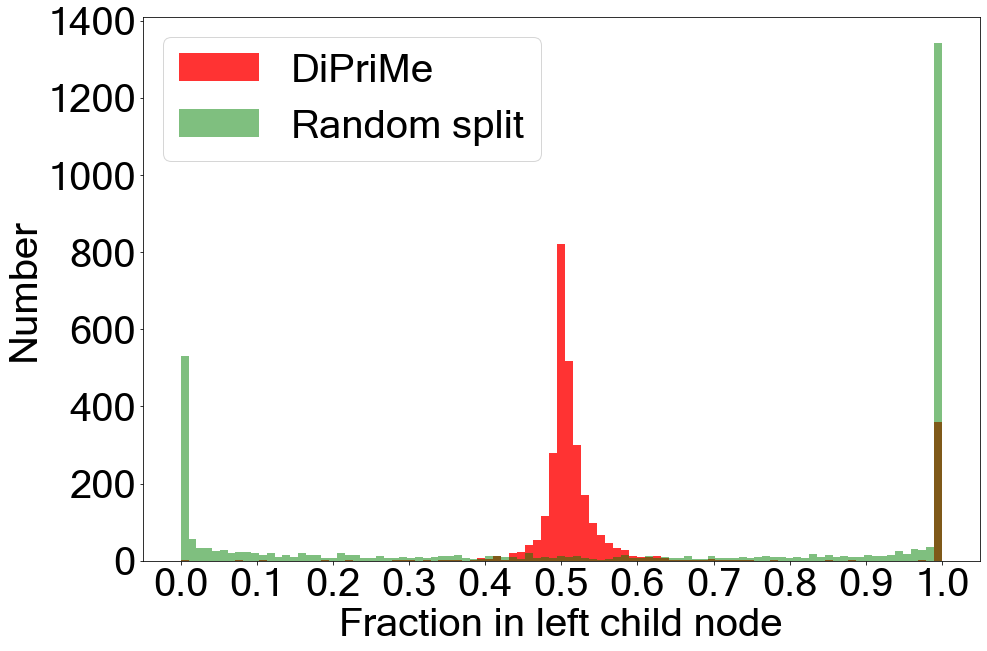

In [54]:
frac_dpmf_val = np.array([item for sublist in list(frac_dpmf.values()) for item in sublist])
frac_dprf_val = np.array([item for sublist in list(frac_dprf.values()) for item in sublist])

bins = np.concatenate((np.linspace(0,0.4,40),np.linspace(0.4,0.6,20),
                      np.linspace(0.6,1.0,40)))
plt.figure(figsize=(15,10))
plt.hist(frac_dpmf_val,bins,density=False,color='r',alpha=0.8,label='DiPriMe')
counts,bins,_ = plt.hist(frac_dprf_val,bins,density=False,color='g',alpha=0.5,label='Random split')

plt.legend(prop={'size':40,'family':'Microsoft Sans Serif'})
plt.xticks(np.linspace(0,1,11,))
plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.xlabel("Fraction in left child node",fontsize=40,fontname='Microsoft Sans Serif')
plt.ylabel("Number",fontsize=40,fontname='Microsoft Sans Serif')
plt.savefig('DiPriMe_Results/frac_hist.png',bbox_inches='tight')

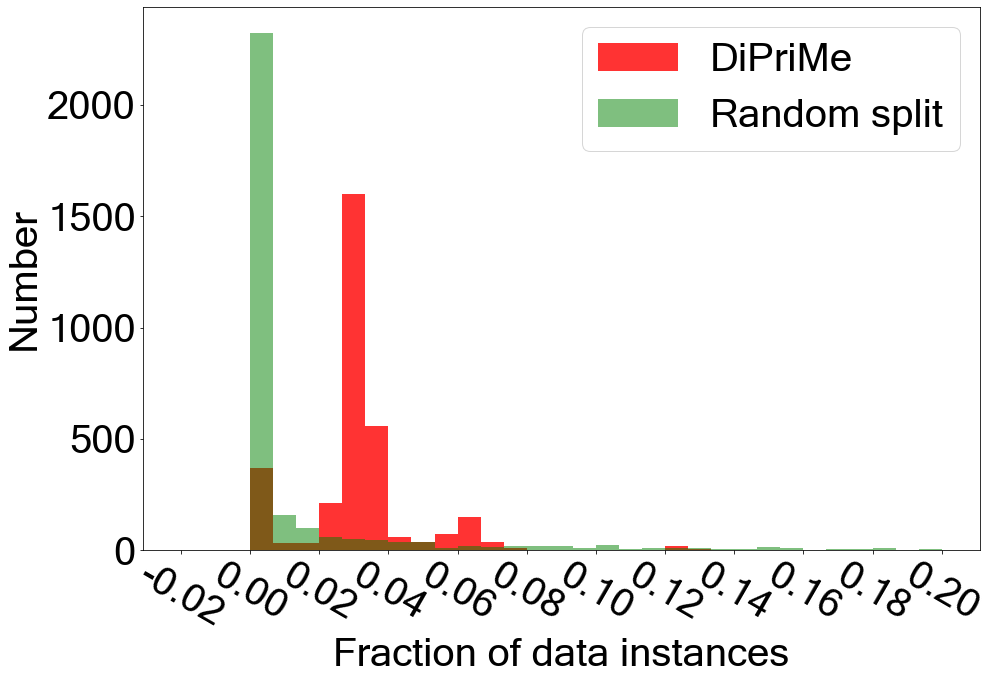

In [55]:
count_dpmf = find_counts(dpmf)
count_dprf = find_counts(dprf)

leaf_counts_dpmf = count_dpmf[5]
leaf_counts_dprf = count_dprf[5]

#bins = np.concatenate((np.linspace(-100,3000,32),np.linspace(3000,18000,16)))
bins = np.linspace(-300,3000,34)
plt.figure(figsize=(15,10))
plt.hist(leaf_counts_dpmf,bins,density=False,color='r',alpha=0.8,label='DiPriMe')
counts,bins,_ = plt.hist(leaf_counts_dprf,bins,density=False,color='g',alpha=0.5,label='Random split')


plt.legend(prop={'size':40,'family':'Microsoft Sans Serif'})
#xticks = np.concatenate((np.linspace(-100,3000,5),np.linspace(3000,bins[-1],5)))
#xtick_labels = ["{:4.3f}".format(x) for x in xticks/count_dpmf[0][0]] #{:3.1e}
xticks = np.linspace(-300,3000,12)
xtick_labels = ["{:4.2f}".format(x) for x in xticks/count_dpmf[0][0]]
plt.xticks(xticks,labels=xtick_labels,rotation=-30) 
plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.xlabel("Fraction of data instances",fontsize=40,fontname='Microsoft Sans Serif')
plt.ylabel("Number",fontsize=40,fontname='Microsoft Sans Serif')
plt.savefig('DiPriMe_Results/leaf_count_hist.png',bbox_inches='tight')